In [1]:
import transformers
#import datasets
import numpy as np
import pandas as pd
import torch
from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

/var/folders/v9/0q93dms13_j7q231ct7r12100000gn/T/ipykernel_99691/4269317467.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id,cache_dir='./')
processor = CLIPProcessor.from_pretrained(model_id,cache_dir='./')
model = CLIPModel.from_pretrained(model_id,cache_dir='./').to(device)

In [4]:
urls=['https://images.unsplash.com/photo-1662955676669-c5d141718bfd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80',
    'https://images.unsplash.com/photo-1552053831-71594a27632d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=662&q=80',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80']

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

In [5]:
text_prompts=["a girl wearing a beanie", "a boy wearing a beanie", "a dog", "a dog at the beach"]
inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

In [6]:
inputs={'input_ids':inputs['input_ids'].to(device),'attention_mask':inputs['attention_mask'].to(device),'pixel_values':inputs['pixel_values'].to(device)}

In [10]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1)
pd.DataFrame(probs.detach().cpu().numpy()*100, columns=text_prompts, index=list(['image1','image2', 'image3'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)

,a girl wearing a beanie,a boy wearing a beanie,a dog,a dog at the beach
image1,99.43,0.56,0.00,0.00
image2,0.65,0.58,87.59,11.18
image3,0.01,0.01,1.03,98.95


In [15]:
logits_per_image

tensor([[29.2717, 24.0998, 17.5929, 15.5132],
        [20.8687, 20.7507, 25.7708, 23.7122],
        [19.6307, 20.1485, 24.8870, 29.4508]], device='mps:0',
       grad_fn=<TBackward0>)

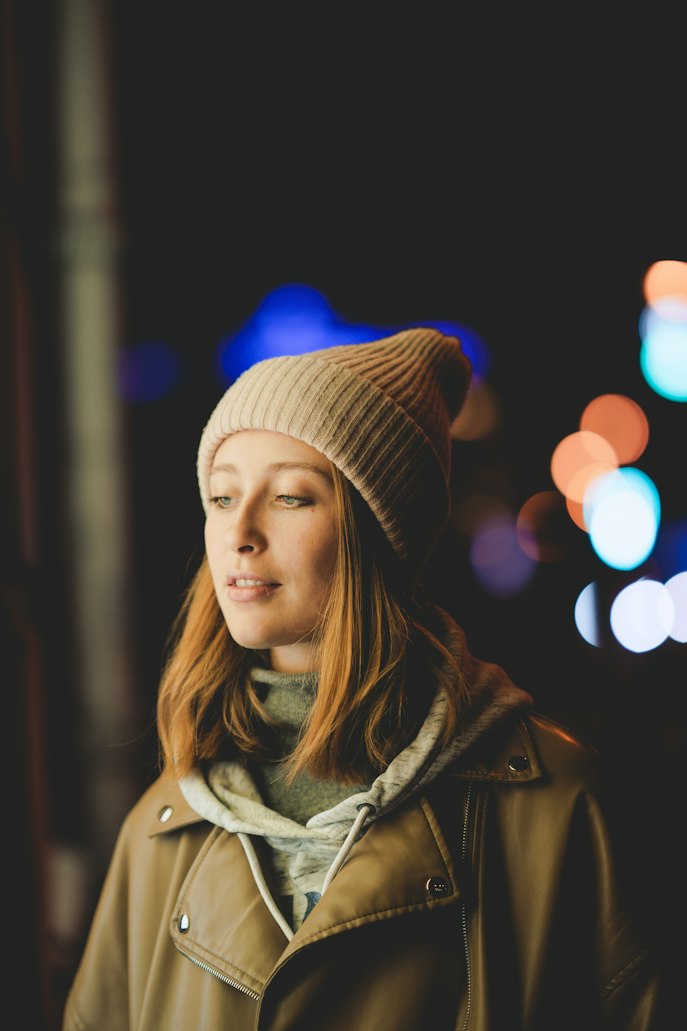

In [12]:
images[0]

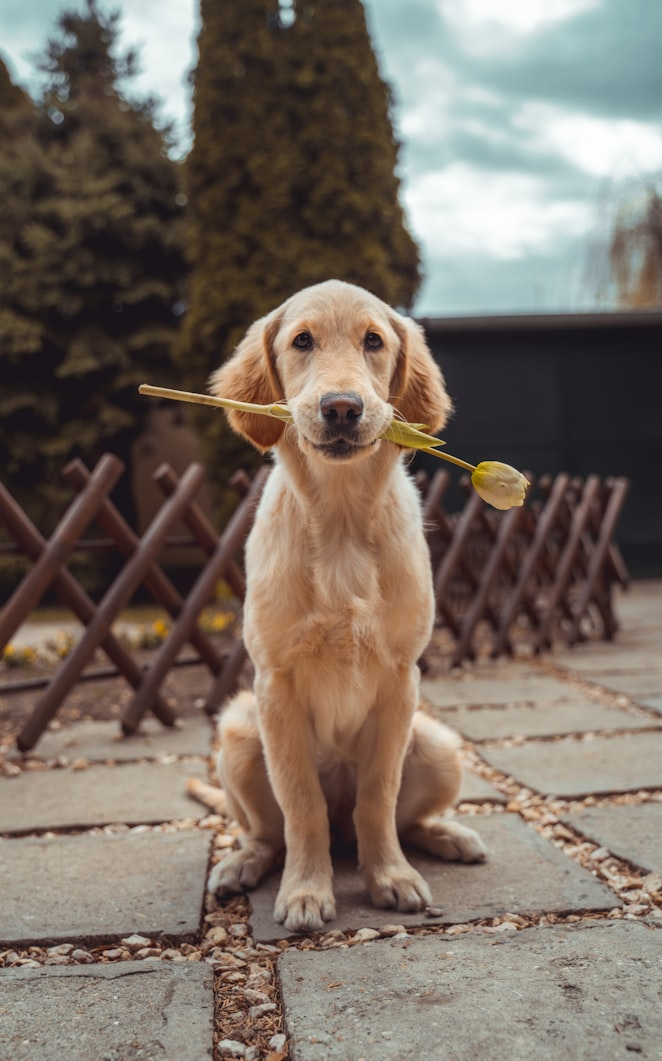

In [13]:
images[1]

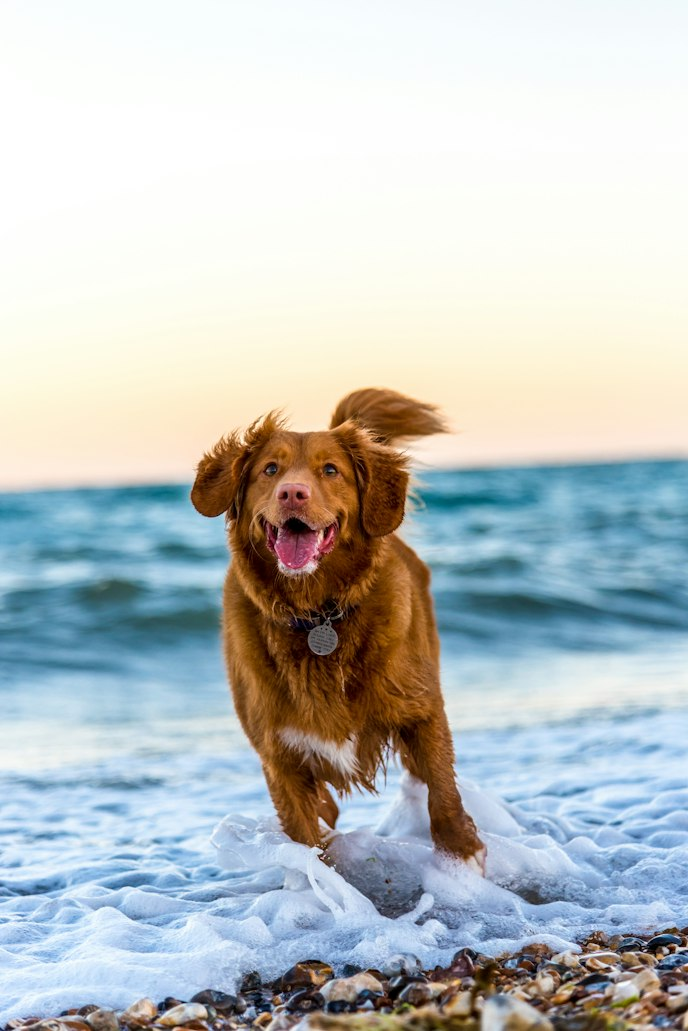

In [14]:
images[2]

In [14]:
inputs['pixel_values'].shape

torch.Size([3, 3, 224, 224])

In [15]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, l